In [9]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [10]:
ro = 1          # Плотность материала
c = 1           # Удельная теплоемкость материала
a = 1           # Константа для функции hi(u)
b = 3           # Коэффициент для функции hi(u)
sigma = 3       # Степень для функции hi(u)
l = 2           # Длина стержня
Q = 10          # Интенсивность источника тепла
t0 = 0.5        # Время, до которого действует функция W2(t)
u0 = 0.1        # Начальное значение температуры

def hi(u):
    """Значение коэффициента теплопроводности в зависимости от температуры"""
    return a + b * u ** sigma

def W2(t):
    """Граничное условие на левой границе стержня"""
    if (t < t0):
        return 2 * Q * t
    else:
        return 0

def avg(a, b):
    u_avg = (a + b) / 2

    return hi(u_avg) / ro / c

In [11]:
def tridiagonal_matrix_algorithm(n: int,
                A: List[float],
                B: List[float],
                C: List[float],
                F: List[float],
                x1: float,
                x2: float,
                m1: float,
                m2: float) -> List[float]:

    a = np.zeros(n + 1)
    b = np.zeros(n + 1)
    y = np.zeros(n + 1)

    a[0] = x1
    b[0] = m1

    for i in range(1, n):
        d = C[i] - A[i] * a[i - 1]
        a[i] = B[i] / d
        b[i] = (F[i] + A[i] * b[i - 1]) / d

    y[n] = (m2 + x2 * b[n - 1]) / (1 - x2 * a[n - 1])

    for i in range(n - 1, -1, -1):
        y[i] = a[i] * y[i + 1] + b[i]

    return y

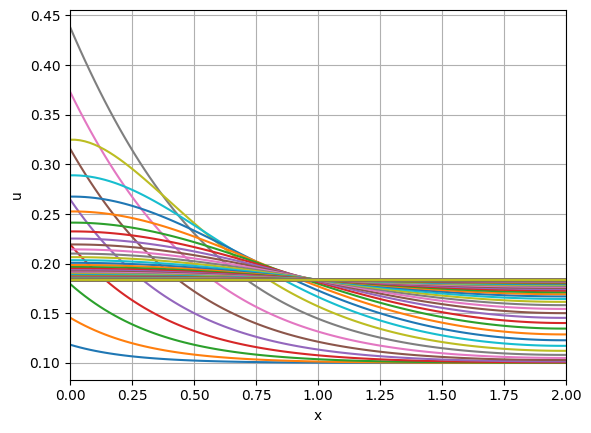

Максимальная температура u_max: 0.1838857200857157 достигается в момент времени T: 59.94


In [12]:
tstep = 1000  # Количество временных шагов
xstep = 100   # Количество пространственных шагов
s = 3         # Количество итераций на каждом временном шаге для улучшения точности

tau = 60 / tstep  # Шаг по времени
h = 2 / xstep     # Шаг по пространству

# Начальные условия
u0 = 0.1                   # Начальное значение температуры (температура в момент времени t=0)
max_temp = -float('inf')   # Инициализация максимальной температуры
max_time = 0               # Инициализация времени, когда достигается максимальная температура

def Solve() -> [float]:
    global max_temp, max_time

    # Массивы для хранения значений температуры на текущем и предыдущем шагах
    y = np.zeros((2, xstep + 1))
    y1 = np.zeros((2, xstep + 1))

    # Массивы для коэффициентов системы уравнений
    a = np.zeros(xstep + 1)
    b = np.zeros(xstep + 1)
    c = np.zeros(xstep + 1)
    f = np.zeros(xstep + 1)

    # Массив для пространственных координат
    x = [i * h for i in range(xstep + 1)]

    # Установка начальных значений температуры для всех точек стержня
    for i in range(xstep + 1):
        y[0][i] = u0

    ind = 1  # Индикатор текущего временного слоя

    for j in range(1, tstep):  # Цикл по временным шагам
        for i in range(0, xstep + 1):
            y1[0][i] = y[1 - ind][i]  # Копируем значения температуры с предыдущего слоя
        ind1 = 1  # Индикатор для нового временного слоя

        for q in range(0, s):  # Итерации для повышения точности решения
            for i in range(1, xstep):  # Цикл по пространственным узлам
                # Вычисление коэффициентов для системы уравнений
                a[i] = avg(y1[1 - ind1][i - 1], y1[1 - ind1][i]) / h**2
                b[i] = avg(y1[1 - ind1][i], y1[1 - ind1][i + 1]) / h**2
                c[i] = (1 / tau + avg(y1[1 - ind1][i - 1], y1[1 - ind1][i]) / h**2 +
                         avg(y1[1 - ind1][i], y1[1 - ind1][i + 1]) / h ** 2)
                f[i] = (y[1 - ind][i] / tau)

            if q == s - 1:
                # Если это последняя итерация, решаем систему уравнений с граничными условиями
                y1[ind1] = tridiagonal_matrix_algorithm(xstep, a, b, c, f, 1, 1, W2(j * tau) * tau * h, 0) # фиксированные граничные условия
            else:
                # Для промежуточных итераций используем предыдущие значения с небольшими поправками
                y1[ind1] = tridiagonal_matrix_algorithm(xstep, a, b, c, f, 0, 0, y[1 - ind][0], y[1 - ind][-1]) # температура на границах не фиксируется
                # температура на левом и правом концах стержня
            ind1 = 1 - ind1

        for i in range(0 , xstep + 1):
            y[ind][i] = y1[1 - ind1][i]   # Обновление значений температуры на текущем слое

        if y[ind][int(100)] > max_temp:
            max_temp = y[ind][int(100)]   # Обновление максимальной температуры
            max_time = j * tau            # Обновление времени достижения максимальной температуры

        if(j * tau > 0):
            plt.plot(x, y[ind], label=f't={j * tau:.2f}')  # Построение графика для текущего временного слоя

        ind = 1 - ind   # Переключение на следующий временной слой

    plt.xlabel('x')
    plt.ylabel('u')
    plt.xlim(0, 2)
    plt.grid(True)
    plt.show()

    return y

results = Solve()
print(f"Максимальная температура u_max: {max_temp} достигается в момент времени T: {max_time:.2f}")

In [13]:
last_index = len(results) - 1
print(", ".join(f"{results[last_index][i]:.4f}" for i in range(xstep + 1)))

0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839, 0.1839


После t=0.5 градиент на левом крае становится равным нулю. Температура будет стремиться к равновесному состоянию.

Максимальная температура будет достигнута тогда, когда температура перестанет изменяться.

В момент времени T>0.5, температура будет равномерно распределена по стержню.